In [ ]:
# default_exp gbe.participants

# Baseline drinking (separate modelling)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

In [ ]:
#export
%load_ext autoreload
%autoreload 2
from trr265.gbe.data_provider import GBEProvider

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# ToDo: This should be moved to stats
from IPython.core.display import display, HTML

def describe(x, description, unit, missing = None, precision = 0, param_precision = 2):
    stats = x.describe()
    stats['unit'] = " " + unit
    descriptive = '''ranged from %%(min).%(precision)df to %%(max).%(precision)df%%(unit)s (<i>M</i> = %%(mean).%(param_precision)df, <i>SD</i> = %%(std).%(param_precision)df).'''%{"precision":precision,"param_precision":param_precision}%stats    
    text = '''%s %s'''%(description, descriptive)
    if missing:
        nmissing = x.isnull().value_counts()[True]
        text = '''%s %s'''%(text, missing%nmissing)
    display(HTML(text))

## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

In [ ]:
dp = GBEProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
ba = dp.get_ba_data(columns = ['mov_id','bx_age', 'screen_gender', 'bx_sozio_gender', 'bx_sozio_genderother'], update = False).groupby('mov_id').first()
print(len(ba))
dp.get_mov_data(update = False)
gbe_data = dp.get_gbe_data(update = False)
# Adding data movisense
df = ba.merge(gbe_data, left_index = True, right_on = 'participant', how = 'right')
# Filtering out replication and ema data
pp_data = df.query("is_initial").groupby('participant').first()
all_pps = df.groupby('participant').first()

544


### Total participants (including non-initial)
#### Difference to live tracking data
The redcap dashboard does not check whether participants actually received a movisense ID. Consequently, it overcounts the number of included participants (redcap shows 581, but actually only 544 are included). Of these, we only have movisense data from 530 participants, and GBE data from 513 participants. Of these 488 participants completed their baseline tasks in the correct time. 

In [ ]:
len(dp.get_mov_data().participant.unique())

530

In [ ]:
len(gbe_data.participant.unique())

513

In [ ]:
len(gbe_data.query('is_baseline==True').participant.unique())

488

In [ ]:
len(df.query('is_baseline==True').participant.unique())

488

In [ ]:
pp_data = df.query('is_baseline==True').groupby('participant').first()

### Gender

In [ ]:
pp_data.screen_gender.value_counts()

2.0    301
1.0    180
3.0      1
Name: screen_gender, dtype: int64

### Age

In [ ]:
describe(pp_data.bx_age, "Participants' age", 'years', param_precision = 1)

### Drinking

In [ ]:
initial_participants = dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']).query("is_initial").participant.unique()
len(initial_participants)

300

#### Drinking days last three months

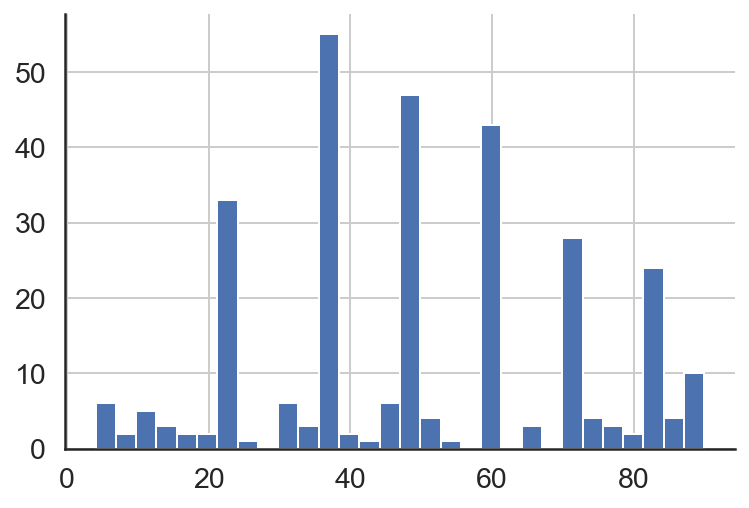

In [ ]:
standard_last_three = dp.get_baseline_drinking_data().loc[initial_participants]
standard_last_three.drinking_days_last_three_month.hist(bins = 30)
sns.despine()

In [ ]:
describe(standard_last_three.drinking_days_last_three_month, 'The total number of drinking days','days', precision = 2)

#### Drinks per drinking day

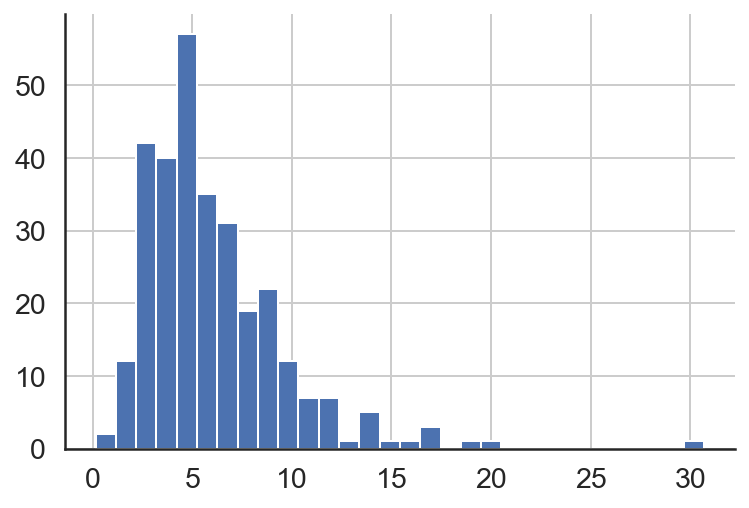

In [ ]:
standard_last_three.drinks_per_drinking_day_last_three_month.hist(bins = 30)
sns.despine()

In [ ]:
describe(standard_last_three.drinks_per_drinking_day_last_three_month, 'Drinks per typical drinking day','standard drinks', precision = 2)

#### Drinks per day

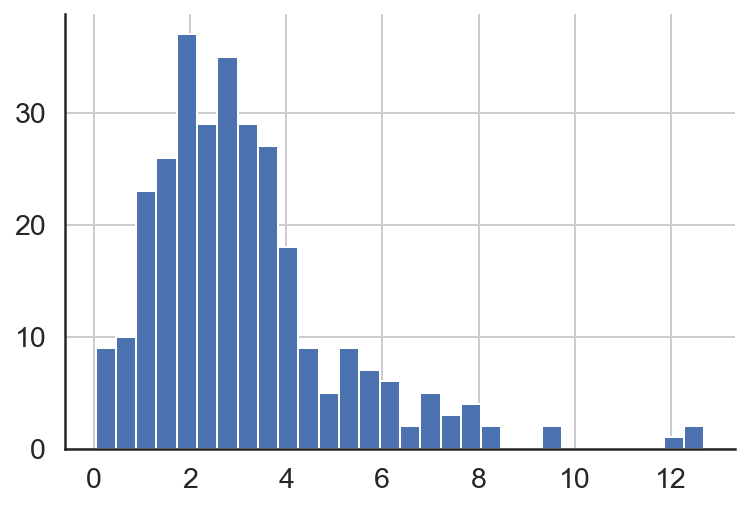

In [ ]:
standard_last_three.last_three_month.hist(bins = 30)
sns.despine()

In [ ]:
describe(standard_last_three.last_three_month, 'Drinks per day day','standard drinks', precision = 2)

### AUD criteria

In [ ]:
participant_list = list(pp_data.redcap_id)

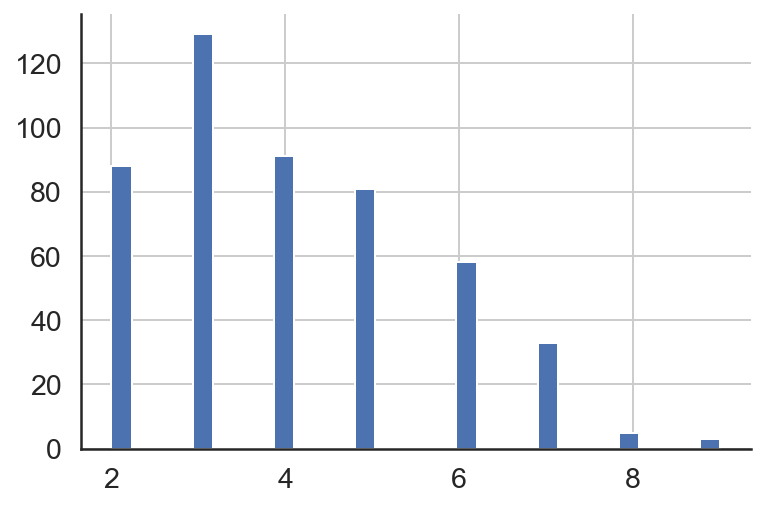

In [ ]:
ba = dp.get_ba_data(columns = ['redcap_event_name','mov_id','bx_aud_sum','participant_id']).query("redcap_event_name=='erhebungszeitpunkt_arm_1'")
ba = ba[ba.participant_id.isin(participant_list)]
aud = ba[~ba.bx_aud_sum.isnull()][['mov_id','bx_aud_sum']]
aud.columns = ['participant','aud']
aud = aud.groupby('participant').first()
aud.aud.hist(bins = 30)
sns.despine()

In [ ]:
describe(aud.aud, 'Fulfilled AUD criteria','')

### Average ema drinking first month

In [ ]:
two_day = dp.get_two_day_data()
average_ema = two_day.query("sampling_day<30").groupby('participant').g_alc.agg(['mean','median'])
average_ema.columns = ['mean_g_alc','median_g_alc']
average_ema = average_ema.reset_index()
average_ema = average_ema[average_ema.participant.isin(initial_participants)].set_index('participant')

<AxesSubplot:>

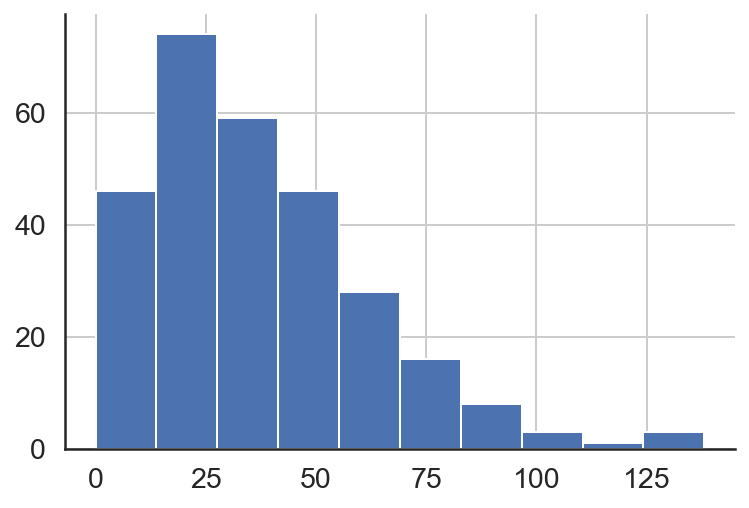

In [ ]:
average_ema.mean_g_alc.hist()

In [ ]:
describe(average_ema.mean_g_alc, 'Mean daily alcohol consumption in first month after the baseline measures','grams')

<AxesSubplot:>

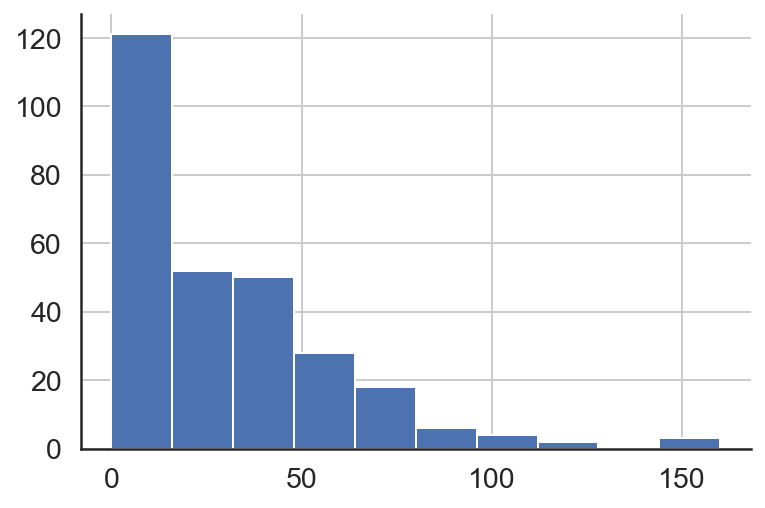

In [ ]:
average_ema.median_g_alc.hist()

In [ ]:
describe(average_ema.median_g_alc, 'Median daily consumption','grams')

### Merging

In [ ]:
average_ema.index.is_unique

True

In [ ]:
drinking = pd.concat([standard_last_three, aud, average_ema],axis = 1)

## Correlations

In [ ]:
import numpy as np
import trr265.stats as stats
import scipy.stats


def correl(df, corr_func = scipy.stats.pearsonr):
    df_corr = pd.DataFrame() # Correlation matrix
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.columns:
        for y in df.columns:
            corr = corr_func(df[x], df[y])
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    return df_corr, df_p

def correlation_matrix(analysis_data, alpha = .05, bonferroni = False, size = (11,9), show_correl = True, corr_func = scipy.stats.pearsonr):
    print(len(analysis_data))

    if bonferroni:
        variables = len(analysis_data.columns)
        correction = ((variables * variables) - variables)/2
        alpha = alpha / correction

    df_corr, df_p = correl(analysis_data, corr_func = corr_func)
    sig = (df_p < alpha).replace({True:"*",False:""})
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    df_corr_label = df_corr.applymap(lambda x: '%.2f'%x)
    df_corr_label = df_corr_label + sig
    if show_correl:
        p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=df_corr_label,fmt = '')
    else:
         p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt = '')       
    p1.text(len(df_corr)-1, 1, "Alpha = %g"%alpha, size='medium', color='black')
    p = df_p.unstack()
    p.index = ['*'.join(map(str,i)) for i in p.index.tolist()]
    p = p.to_dict()
    corr = df_corr.unstack()
    corr.index = ['*'.join(map(str,i)) for i in corr.index.tolist()]
    corr = corr.to_dict()

### Drinking

#### Pearson

284


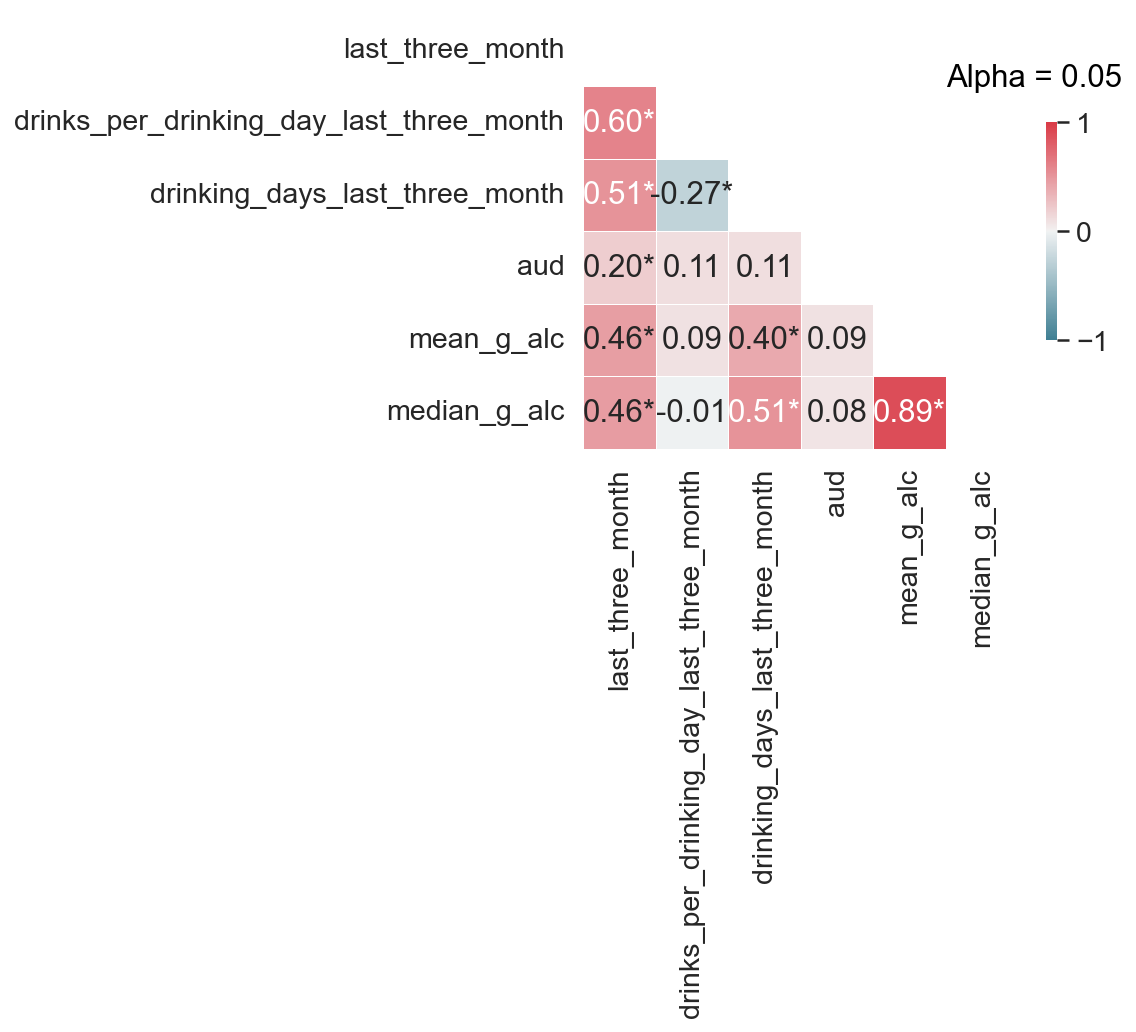

In [ ]:
correlation_matrix(drinking.dropna(), size = (5,4))

284


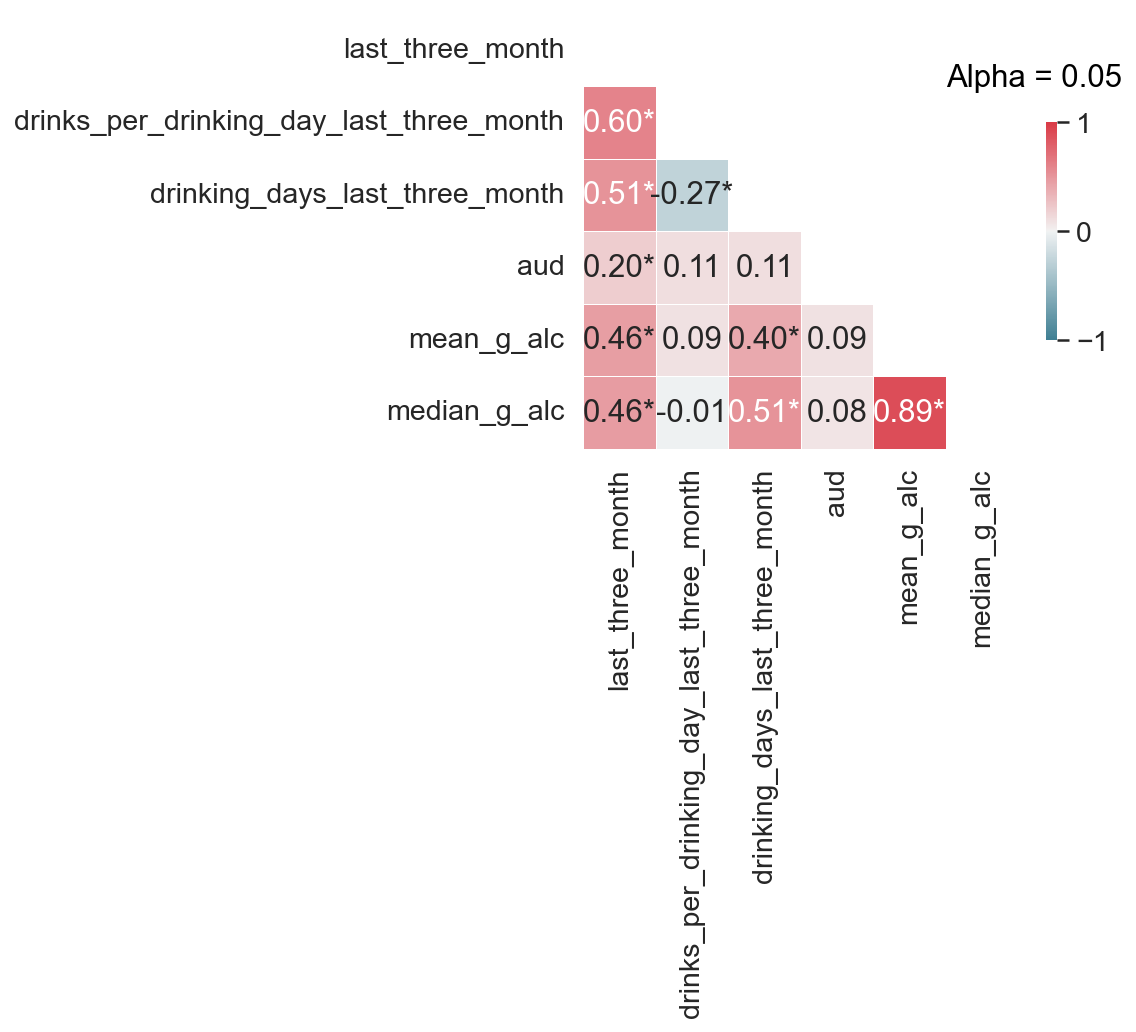

In [ ]:
correlation_matrix(drinking.dropna(), size = (5,4))

#### Spearman

284


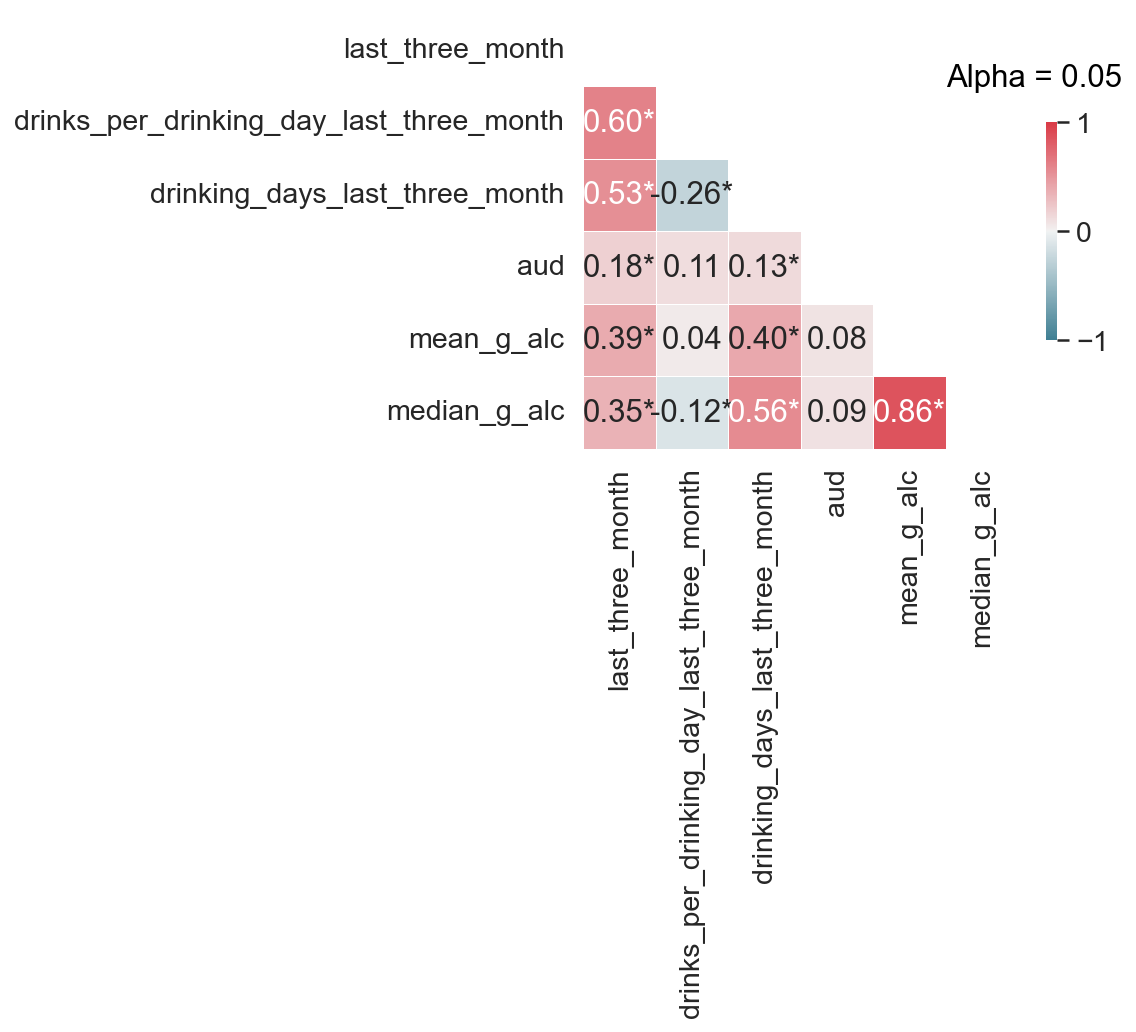

In [ ]:
correlation_matrix(drinking.dropna(), size = (5,4), corr_func = scipy.stats.spearmanr)

### Tasks

In [ ]:
tasks = pd.concat([wm, sst, rtt,ist],axis = 1)

NameError: name 'wm' is not defined

#### Pearson

In [ ]:
correlation_matrix(tasks.dropna(), size = (10,8))

- Working memory scores correlate with each other.  
- RTT mixed correlates positvely with rtt win and rtt loss.
- SSRTs correlate negatively with working memory.  
- RTT win correlates positively with wm no distractor 1 and wm delayed and negatively with SSRTs.  
- RTT loss correlates positively with SSRTs.
- RTT mixed correlates negatively with wm encoding.
- Oversampling correlates negatively with rtt loss.

#### Spearman

In [ ]:
correlation_matrix(tasks.dropna(), size = (10,8), corr_func = scipy.stats.spearmanr)

- Correlation between RTT win and wm delayed gone.
- Correlation RTT mixed correlates negatively with wm encoding gone.
- Oversampling now also negatively correlates with wm_no_1. 

### Together

#### Pearson

In [ ]:
correlation_matrix(pd.concat([tasks, drinking],axis = 1).dropna(), size = (12,10))

#### Spearman

In [ ]:
all_data = pd.concat([tasks, drinking],axis = 1).dropna()
correlation_matrix(all_data, size = (12,10), corr_func = scipy.stats.spearmanr)

##### WM_encoding and last_three_month
Effect in the opposite direction as expected.

In [ ]:
sns.regplot(x = 'wm_encoding', y = 'last_three_month', data = all_data)

##### SSRT and last_three_month
Effect in the opposite direction as expected.

In [ ]:
sns.regplot(x = 'ssrt', y = 'last_three_month', data = all_data)

##### WM no distractor 1 and median ema drinking
Effect in the opposite direction as expected.

In [ ]:
sns.regplot(x = 'wm_no_1', y = 'median_g_alc', data = all_data)

##### WM encoding and median ema drinking
Effect in the opposite direction as expected.

In [ ]:
sns.regplot(x = 'wm_encoding', y = 'median_g_alc', data = all_data)

##### WM delayed and median ema drinking
Effect in the opposite direction as expected.

In [ ]:
all_data.wm_delayed.hist()

In [ ]:
sns.regplot(x = 'wm_delayed', y = 'median_g_alc', data = all_data)

In [ ]:
sns.regplot(x = 'ssrt', y = 'median_g_alc', data = all_data)

This would mean that on most days participants do not drink.

In [ ]:
two_day